In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import umap

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers, losses, activations, models, initializers, regularizers, constraints
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Layer, Dense, Input, Dropout, Convolution1D, Conv1D, MaxPool1D, GlobalMaxPool1D,GlobalAveragePooling1D
from tensorflow.keras.layers import BatchNormalization, Bidirectional, LSTM, Flatten, Permute, Concatenate, Reshape, Cropping1D, Lambda, Conv1DTranspose
from tensorflow.keras.models import load_model, Model, Sequential

# Import sklearn
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder

# custom modules
from utils import *
from cf_matrix import *
from data import get_tsfel_features


from livelossplot import PlotLossesKeras

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0" # select GPU

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## MITBIH Model

In [5]:
WINDOW_SIZE = 187
NO_CLASSES = 5
SAMPLING_RATE = 125.0

### Load data

In [92]:
df_train = pd.read_csv("./data/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1, random_state=42)
df_test = pd.read_csv("./data/mitbih_test.csv", header=None)

Y_train = np.array(df_train[187].values).astype(np.int8)
X_train = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [93]:
# Make a train test split for the VAE
X, X_val, Y, Y_val = train_test_split(
    X_train, Y_train, test_size=0.1, random_state=42, stratify=Y_train)

In [94]:
print("Train", X.shape, Y.shape)
print("Test", X_val.shape, Y_val.shape)
print("Test", X_test.shape, Y_test.shape)

Train (78798, 187, 1) (78798,)
Test (8756, 187, 1) (8756,)
Test (21892, 187, 1) (21892,)


In [95]:
# One-Hot encode labels
oh_encoder = OneHotEncoder(sparse=False)
oh_encoder.fit(Y.reshape(-1,1))
Y_oh = oh_encoder.transform(Y.reshape(-1,1))
Y_val_oh = oh_encoder.transform(Y_val.reshape(-1,1))
Y_test_oh = oh_encoder.transform(Y_test.reshape(-1,1))

In [96]:
print("Label shape:", Y_oh.shape, Y_test_oh.shape)

Label shape: (78798, 5) (21892, 5)


### Heartbeat classes

In [97]:
hb_classes = { 0 : 'normal (N)',          # normal beat
               1 : 'SVEB (S)',            # supraventricular ectopic beat (SVEB)
               2 : 'VEB (V)',             # ventricular ectopic beat (VEB)
               3 : 'Fusion beat (F)',     # fusion beat (F)
               4 : 'unknown beat typ (Q)' # unknown beat type (Q)
             }

### Class weights

In [98]:
cls_weights = class_weight.compute_class_weight('balanced', classes = np.unique(Y),  y = Y)
cls_weight_dict = dict(enumerate(cls_weights))

#### Distribution plot of hearbeat templates

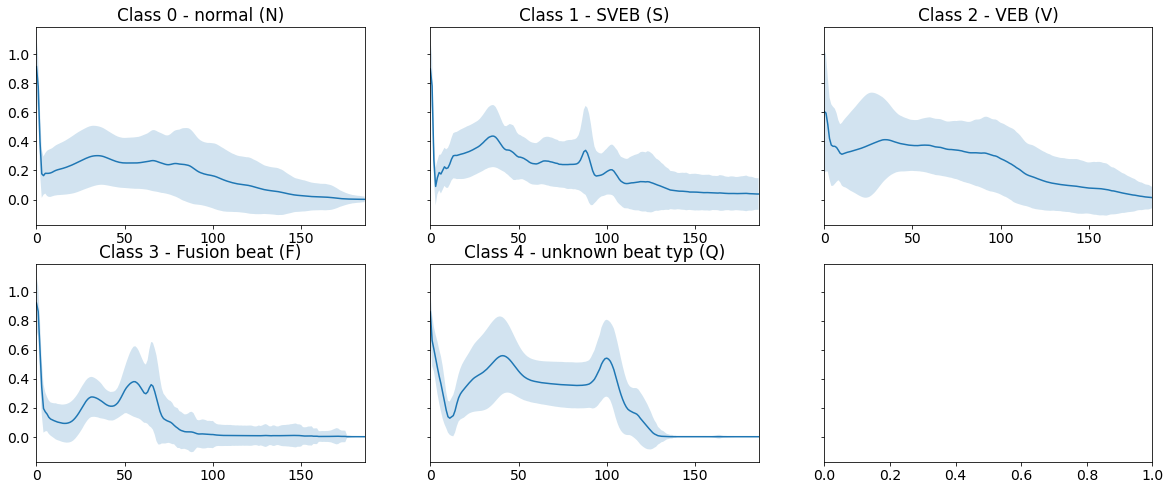

In [99]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(20,8))

for cid, ax in enumerate(axes.flatten()[:5]):
    hb_plot(ax, X[Y==cid].squeeze())
    ax.set_title("Class {} - {}".format(cid, hb_classes[cid]))

## Conditional CNN VAE
Based on:
- Conditional VAE implementation https://gist.github.com/naotokui/2201cf1cab6608aee18d34c0ea748f84
- VAE implementation: https://keras.io/examples/generative/vae/

In [100]:
# training parameters
EPOCHS = 1000
BATCH_SIZE = 128

# vae hyperparameter
LATENT_SPACE_DIM = 4

### Encoder

#### Sampling

In [359]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [360]:
def get_encoder():
    # Q(z|X) -- encoder
    input_template = Input(shape=(WINDOW_SIZE, 1))

    # extract features from input
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(input_template)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = BatchNormalization()(img_1)

    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = BatchNormalization()(img_1)

    img_1 = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = BatchNormalization()(img_1)

    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)

    img_1 = GlobalMaxPool1D()(img_1)

    # Label input for conditioning
    input_cond = Input(shape=(NO_CLASSES))

    inputs_merged = Concatenate()([img_1, input_cond])
    encoder_1 = Dense(256, activation='relu')(inputs_merged)
    z_mean = Dense(LATENT_SPACE_DIM, activation='linear', name="z_mean")(encoder_1) # predicted mode
    z_log_var = Dense(LATENT_SPACE_DIM, activation='linear', name="z_log_var")(encoder_1) # predicted variance
    
    z = Sampling()([z_mean, z_log_var]) # Sampling Layer
    z_cond = Concatenate()([z, input_cond]) # conditional upsampling
    
    encoder = tf.keras.Model([input_template, input_cond], [z_mean, z_log_var, z], name="encoder")
    
    return encoder

In [361]:
encoder = get_encoder()
# encoder.summary()
# tf.keras.utils.plot_model(encoder, show_shapes=True)

### Decoder

In [362]:
def get_decoder():
    
    d_cond = Input(shape=(NO_CLASSES))
    d_z = Input(shape=(LATENT_SPACE_DIM))
    d_inputs = Concatenate()([d_z, d_cond]) # condition decoding on label

    DENSE_WINDOWS_MULT = 32
    DIVISOR = 16

    d_1 = Dense(DENSE_WINDOWS_MULT * (WINDOW_SIZE // DIVISOR + 1), activation='relu')(d_inputs)
    r_1 = Reshape(target_shape=(WINDOW_SIZE // DIVISOR + 1, DENSE_WINDOWS_MULT))(d_1)
    conv_trans_1 = Conv1DTranspose(filters=32, kernel_size=5, strides=4, padding="same", activation="relu")(r_1)
    conv_trans_2 = Conv1DTranspose(filters=16, kernel_size=3, strides=2,
                                   padding="same", activation="sigmoid")(conv_trans_1)
    conv_trans_3 = Conv1DTranspose(filters=8, kernel_size=3, strides=2,
                                   padding="same", activation="sigmoid")(conv_trans_2)
    conv_trans_4 = Conv1DTranspose(filters=1, kernel_size=3, strides=1,
                                   padding="same", activation="sigmoid")(conv_trans_3)

    cropped = Cropping1D((0,5))(conv_trans_4)
    decoder = Model([d_z, d_cond], cropped, name="decoder")
    return decoder

In [363]:
decoder = get_decoder()
# decoder.summary()

### VAE Model

In [364]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        return self.decoder([z, data[1]])
    
    def test_step(self, data):
        
        # Encode input
        z_mean, z_log_var, z = self.encoder(data)
        
        # Decode i.e. reconstruct
        reconstruction = self.decoder([z, data[0][1]])
        
        # Compute reconstruction loss
        reconstruction_entropy = tf.keras.losses.binary_crossentropy(data[0][0], reconstruction)
        reconstruction_entropy_sum = tf.reduce_sum(reconstruction_entropy, axis=(1))
        reconstruction_loss = tf.reduce_mean(reconstruction_entropy_sum)
        
        # Compute KL Divergence of variational distribution and prior distribution
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        # Compute combined loss
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def train_step(self, data):
        with tf.GradientTape() as tape:
            
            # Encode/Decode input
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder([z, data[0][1]])
            
            # Compute loss
            reconstruction_entropy = tf.keras.losses.binary_crossentropy(data[0][0], reconstruction)
            reconstruction_entropy_sum = tf.reduce_sum(reconstruction_entropy, axis=(1))
            reconstruction_loss = tf.reduce_mean(reconstruction_entropy_sum)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        # Collect statistics
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Traininig

In [365]:
# Initialize VAE
vae = VAE(encoder, decoder)

# Compile VAE model
opt = optimizers.Adam() # learning_rate=0.001
vae.compile(optimizer=opt)

#### Fitting

In [252]:
# Parameter for ReduceLROnPlateau callback
min_lr           = 0.00005 # 0.00005
reduce_lr_factor = 0.5     # 0.8
patience         = 5
cooldown         = 5 


weight_file_path = "./models/conditional_cnn_vae_mitbih"
monitor_loss = "val_loss"
checkpoint = ModelCheckpoint(weight_file_path, monitor=monitor_loss, verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor=monitor_loss, mode="min", patience=8, verbose=1)
redonplat = ReduceLROnPlateau(monitor=monitor_loss, mode="min", factor=reduce_lr_factor, patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=2)

callbacks_list = [checkpoint, early, redonplat, PlotLossesKeras()]

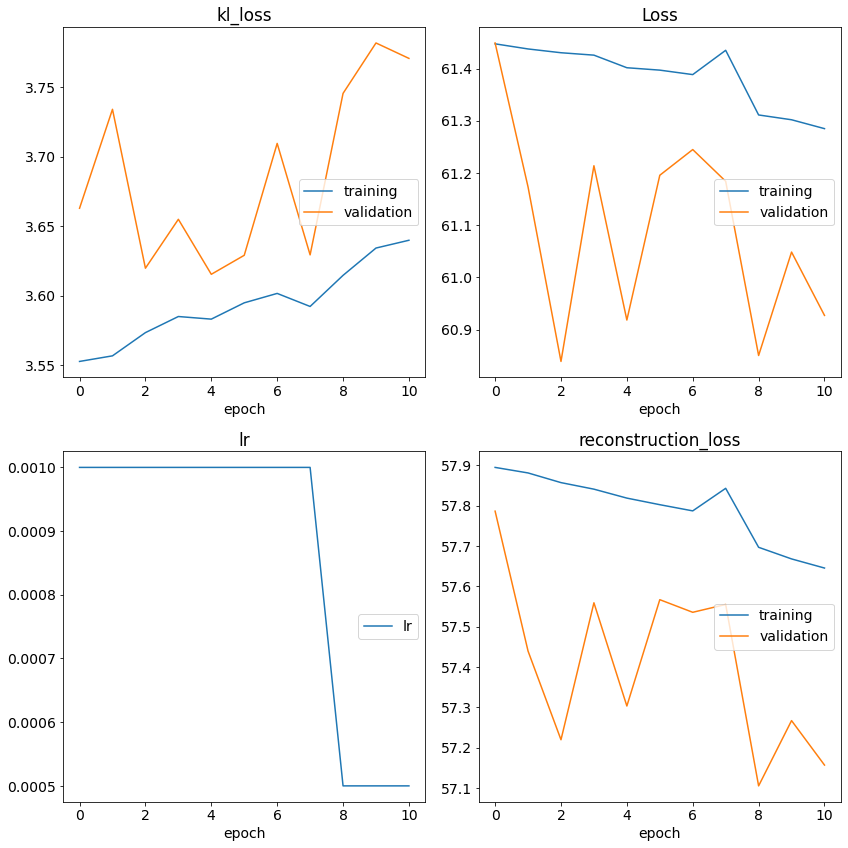

kl_loss
	training         	 (min:    3.553, max:    3.640, cur:    3.640)
	validation       	 (min:    3.615, max:    3.782, cur:    3.771)
Loss
	training         	 (min:   61.285, max:   61.447, cur:   61.285)
	validation       	 (min:   60.839, max:   61.449, cur:   60.927)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
reconstruction_loss
	training         	 (min:   57.645, max:   57.895, cur:   57.645)
	validation       	 (min:   57.105, max:   57.786, cur:   57.157)
Epoch 00011: early stopping


In [253]:
vae.fit(
    x=[X, Y_oh], epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True, 
    callbacks=callbacks_list,
    validation_data=[X_val, Y_val_oh],
    shuffle=True
)

### VAE Evaluation

#### Latent space embedding distribution

In [110]:
def plot_label_clusters(vae, data, labels):
    
    # Create figure
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16,8))

    # Encode data
    z_mean, _, _ = vae.encoder.predict([data, labels])
    
    # Compute UMAP projection (2 components)
    ump = umap.UMAP(n_components=2, verbose=False)
    embedding_umap = ump.fit_transform(z_mean)
    
    # Visualize UMAP
    viz_data_umap = pd.concat([
        pd.DataFrame(embedding_umap[:,:2]),
        pd.DataFrame(["umap"]*embedding_umap.shape[0]), 
        pd.DataFrame(oh_encoder.inverse_transform(labels))],
    axis=1)
    viz_data_umap.columns=["Comp1","Comp2","dimred","values"]

    sns.scatterplot(data=viz_data_umap,x="Comp1",y="Comp2",hue="values", palette="tab10", ax=axes[0])
    axes[0].set_title("UMAP representation of data",size=20)
    
    # Visualize embeddings (first two dimensions)
    axes[1].scatter(z_mean[:, 0], z_mean[:, 1], c=oh_encoder.inverse_transform(labels), cmap="tab10")
    axes[1].set_xlabel("z[0]")
    axes[1].set_ylabel("z[1]")
    plt.show()

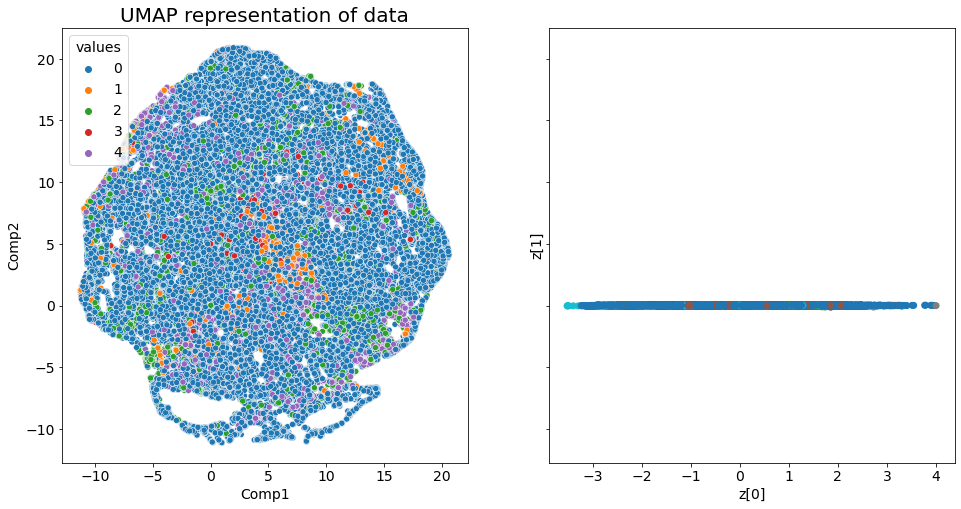

In [111]:
plot_label_clusters(vae, X[0:], Y_oh[0:])

#### Analyse generated templates

In [112]:
def plot_latent_space(vae, n=2, plot_individual=True, label=0):
    
    print(f"Generating samples of Class {label}")
    class_label = np.array([label]).reshape(-1, 1)
    samples = []
    
    if plot_individual:
        fig, axes = plt.subplots(nrows=n+1, ncols=1, sharey=True, figsize=(12,6))
    else:
        fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(12,6))
        
    x = np.arange(WINDOW_SIZE) 

    # Generate n different random samples in the latent space
    for i in range(n):
        z_sample = np.random.normal(0, scale=1.0, size=(1, LATENT_SPACE_DIM))
        cl = np.array(oh_encoder.transform(class_label))
        x_decoded = vae.decoder.predict([z_sample, cl])
        x_reshaped = x_decoded[0].reshape(WINDOW_SIZE)
        samples.append(x_reshaped)
        
        if plot_individual:
            axes[i].plot(x, x_reshaped)
       
    axis = axes
    if plot_individual:
        axis = axes[n]
    
    # Plot distribution of generated templates
    est = np.mean(samples, axis=0)
    sd = np.std(samples, axis=0)
    cis = (est - sd, est + sd)
    axis.fill_between(x,cis[0],cis[1],alpha=0.2)
    axis.plot(x, est)
    axis.margins(x=0)
    
    plt.show()
        
        


Generating samples of Class 4


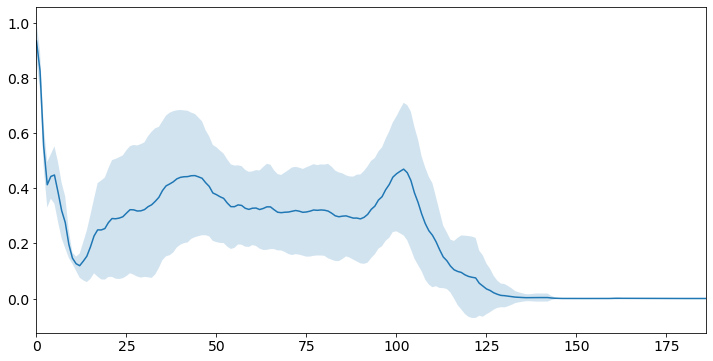

In [113]:
plot_latent_space(vae, n=20, label=4, plot_individual=False)

### Generate additional data
Using the trained VAE decoder

In [254]:
# Generate data using the trained VAE
def generate_training_samples(n, classes=[0,1,2,3,4]):
    
    # U.a.r choose a label from the input class label set
    labels = np.random.choice(classes, n, replace=True).reshape(-1, 1)
    labels_oh = oh_encoder.transform(labels)
    
    # Sample from latent space
    latent_samples = z_sample = np.random.normal(0, scale=1.0, size=(n, LATENT_SPACE_DIM))
    
    # Decode latent space
    decoded_samples = vae.decoder.predict([latent_samples, labels_oh])
    
    return decoded_samples, labels_oh, labels

In [255]:
# Generate data using the trained VAE
X_add, Y_add_oh, Y_add = generate_training_samples(120000, classes=[0,0,0,1,2,3,4])

In [256]:
# Combine actual training data with the generated data
X_comb = np.concatenate((X, X_add))
Y_comb = np.concatenate((Y, Y_add.reshape(-1)))
Y_comb_oh = np.concatenate((Y_oh, Y_add_oh))
print("Combined training data shape:", X_comb.shape, Y_comb_oh.shape)

Combined training data shape: (198798, 187, 1) (198798, 5)


#### Analyze class distribution of combineddata

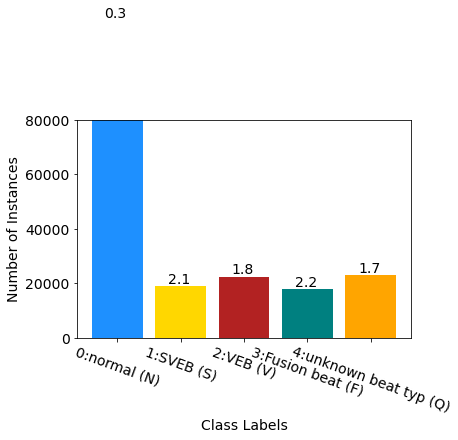

In [257]:
cls_weights_additional = class_weight.compute_class_weight('balanced', classes = np.unique(Y_comb),  y = Y_comb)
cls_weight_dict_additional = dict(enumerate(cls_weights_additional))

# plot class distribution
colors = ["dodgerblue", "gold", "firebrick", "teal", "orange"]
x = np.arange(0,5)
h, bins = np.histogram(Y_comb, 5)
plt.bar(x, h, color=colors)
plt.xlabel('Class Labels')
plt.ylabel('Number of Instances')
plt.xticks(x, [f"{i}:{hb_classes[i]}" for i in x], rotation=-20)
plt.ylim(0, 80000)

for index, value in enumerate(h):
    plt.text(x[index]-0.2, value+1000, str(np.round(cls_weight_dict_additional[index],1)))

plt.show()

### Train CNN on generated data

In [258]:
# Import baseline CNN
def get_model():
    
    nclass = NO_CLASSES
    inp = Input(shape=(187, 1))
    
    # --------------------------------
    # CNN
    # --------------------------------
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = BatchNormalization()(img_1)
    
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = BatchNormalization()(img_1)
    
    img_1 = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(64, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    img_1 = BatchNormalization()(img_1)
    
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    
    
    # Original Head
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)
    dense_1 = Dense(128, activation=activations.relu, name="dense_1")(img_1)
    
    
    # --------------------------------
    # Dense Head
    # --------------------------------
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    
    return model

In [259]:
# Create model
model = get_model()

In [260]:
# Compile model
opt = optimizers.Adam(0.001)
model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

In [261]:
# Parameter for ReduceLROnPlateau callback
min_lr           = 0.00005 # 0.00005
reduce_lr_factor = 0.5     # 0.8
patience         = 5
cooldown         = 5 


weight_file_path_vae_cnn = "./models/vae_data_cnn_mitbih.h5"
checkpoint = ModelCheckpoint(weight_file_path_vae_cnn, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=8, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=reduce_lr_factor, patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=2)

callbacks_list = [checkpoint, early, redonplat, PlotLossesKeras()]
# callbacks_list = [checkpoint, early, redonplat]

In [262]:
BATCH_SIZE_CNN = 128

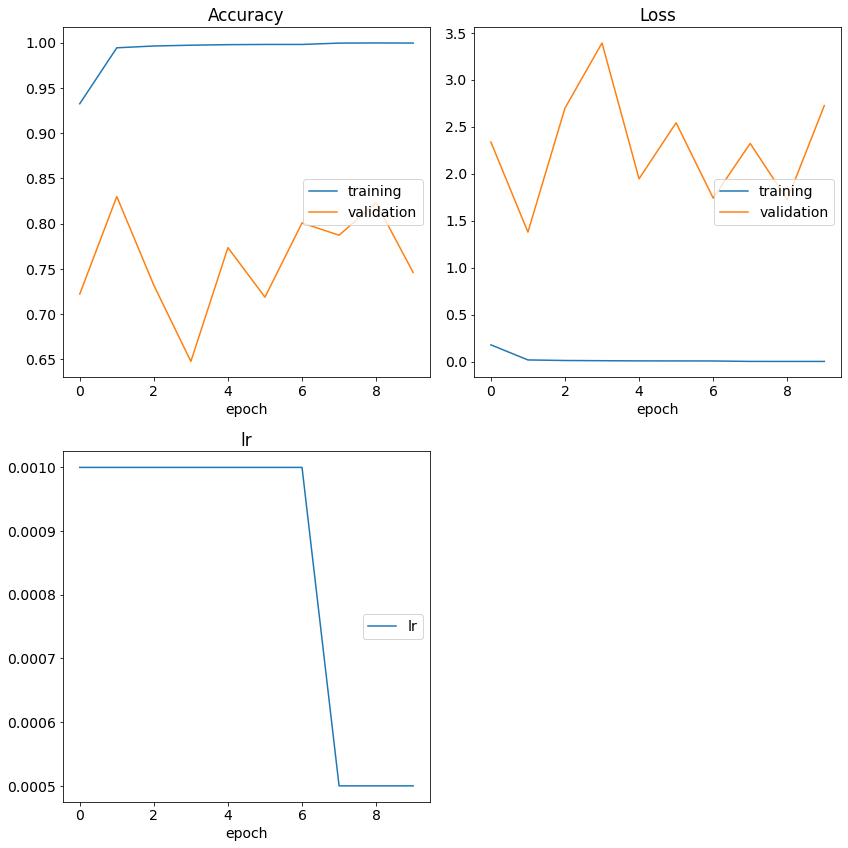

Accuracy
	training         	 (min:    0.932, max:    1.000, cur:    1.000)
	validation       	 (min:    0.648, max:    0.830, cur:    0.746)
Loss
	training         	 (min:    0.001, max:    0.178, cur:    0.001)
	validation       	 (min:    1.378, max:    3.393, cur:    2.725)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
Epoch 00010: early stopping


In [263]:
model.fit(
    X_add, Y_add, # Train on generated data alone
    epochs=EPOCHS, batch_size=BATCH_SIZE_CNN, verbose=True, 
    callbacks=callbacks_list,
    validation_data=(X_val, Y_val), # validate on actual data
    shuffle=True,
)

In [264]:
# load best model
model.load_weights(weight_file_path_vae_cnn)

f1 score micro:           0.82752
f1 score macro:           0.51206
accuracy score:           0.82752
balanced accuracy score:  0.61045


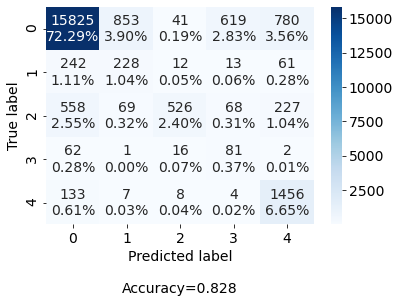

In [265]:
pred_test_proba = model.predict(X_test)
pred_test = np.argmax(pred_test_proba, axis=-1)

# print("F1 Macro:", f1_score(Y_test, pred_test, average="macro"))
display_result(Y_test, pred_test)

# PTB

#### Load data

In [266]:
df_1_ptb = pd.read_csv("./data/ptbdb_normal.csv", header=None)
df_2_ptb = pd.read_csv("./data/ptbdb_abnormal.csv", header=None)
df_ptb = pd.concat([df_1_ptb, df_2_ptb])

df_train_ptb, df_test_ptb = train_test_split(df_ptb, test_size=0.2, random_state=1337, stratify=df_ptb[187])


Y_train_ptb = np.array(df_train_ptb[187].values).astype(np.int8)
X_train_ptb = np.array(df_train_ptb[list(range(187))].values)[..., np.newaxis]

Y_test_ptb = np.array(df_test_ptb[187].values).astype(np.int8)
X_test_ptb = np.array(df_test_ptb[list(range(187))].values)[..., np.newaxis]

In [267]:
# Make a train test split for the VAE
X_ptb, X_val_ptb, Y_ptb, Y_val_ptb = train_test_split(
    X_train_ptb, Y_train_ptb, test_size=0.1, random_state=42, stratify=Y_train_ptb)

In [268]:
# One-Hot encode labels
# Use same encoder as for MITBIH data set, will leave trailing three positions always at 0
# but facilitates network reuse, as the inputs will always stay 0, the network will not
# learn/predict or adjust any gradients based on it.
Y_ptb_oh = oh_encoder.transform(Y_ptb.reshape(-1,1))
Y_val_ptb_oh = oh_encoder.transform(Y_val_ptb.reshape(-1,1))
Y_test_ptb_oh = oh_encoder.transform(Y_test_ptb.reshape(-1,1))

#### Class weights

In [275]:
cls_weights_ptb = class_weight.compute_class_weight('balanced', classes = np.unique(Y_train_ptb),  y = Y_train_ptb)
print(cls_weights_ptb)

[1.79811554 0.69258686]


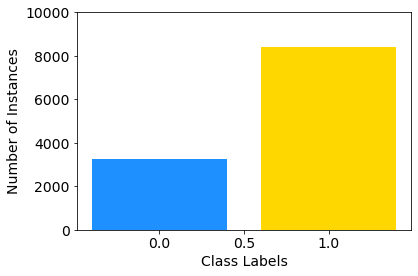

In [280]:
# plot class distribution
colors = ["dodgerblue", "gold"]
x = np.arange(0,2)
h, bins = np.histogram(Y_train_ptb, 2)
plt.bar(x, h, color=colors)
plt.xlabel('Class Labels')
plt.ylabel('Number of Instances')
plt.ylim(0, 10000)

plt.show()

##  VAE Training

In [340]:
TRANSFER = False

In [341]:
encoder_ptb = get_encoder()
decoder_ptb = get_decoder()

In [342]:
# Initialize VAE
vae_ptb_raw = VAE(encoder_ptb, decoder_ptb)

# Compile VAE model
opt = optimizers.Adam() # learning_rate=0.001
vae_ptb_raw.compile(optimizer=opt)

##### Load weights if transfer learning

In [343]:
if TRANSFER:
    print("Loading pretrained VAE weights from MITBIH data set")
    vae_ptb_raw.load_weights(weight_file_path)

### Compile and fit VAE on PTB

In [344]:
# Parameter for ReduceLROnPlateau callback
min_lr           = 0.00005 # 0.00005
reduce_lr_factor = 0.5     # 0.8
patience         = 5
cooldown         = 5 


weight_file_path_ptb_vae = "./models/vae_ptb"
monitor_loss = "val_loss"
checkpoint = ModelCheckpoint(weight_file_path_ptb_vae, monitor=monitor_loss, verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor=monitor_loss, mode="min", patience=8, verbose=1)
redonplat = ReduceLROnPlateau(monitor=monitor_loss, mode="min", factor=reduce_lr_factor, patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=2)

callbacks_list = [checkpoint, early, redonplat, PlotLossesKeras()]

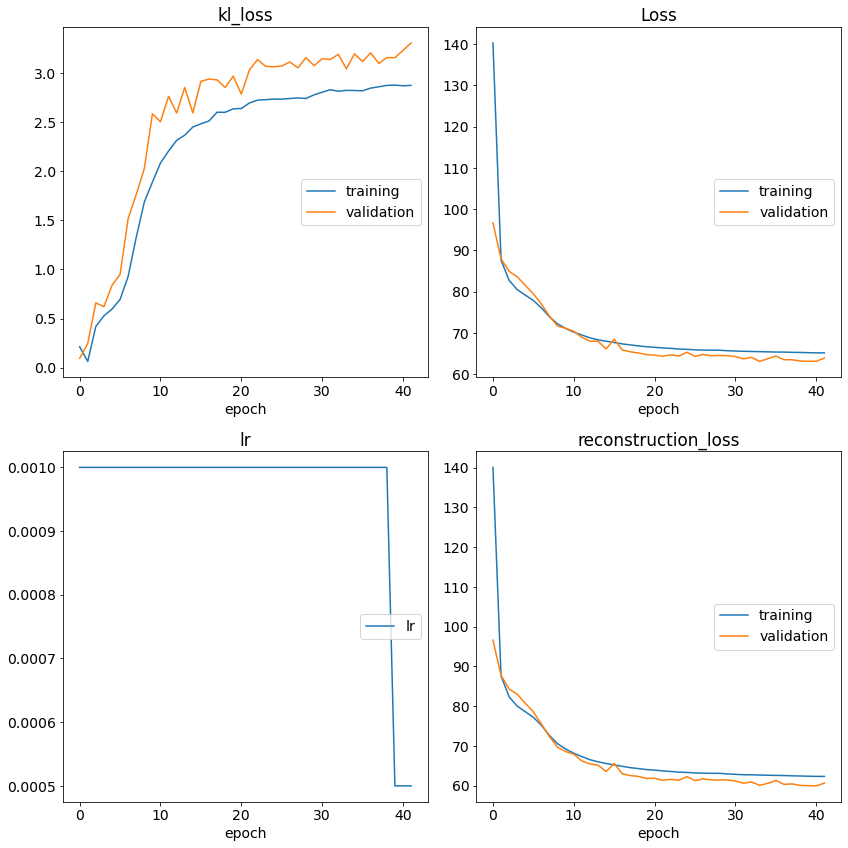

kl_loss
	training         	 (min:    0.062, max:    2.880, cur:    2.877)
	validation       	 (min:    0.094, max:    3.309, cur:    3.309)
Loss
	training         	 (min:   65.189, max:  140.280, cur:   65.189)
	validation       	 (min:   63.118, max:   96.693, cur:   63.944)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
reconstruction_loss
	training         	 (min:   62.312, max:  140.067, cur:   62.312)
	validation       	 (min:   59.935, max:   96.600, cur:   60.634)
Epoch 00042: early stopping


In [345]:
vae_ptb_raw.fit(
    x=[X_ptb, Y_ptb_oh], epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=True, 
    callbacks=callbacks_list,
    validation_data=[X_val_ptb, Y_val_ptb_oh],
    shuffle=True
)

In [346]:
# Load best model
vae_ptb_raw.load_weights(weight_file_path_ptb_vae)

### Inspect results

Generating samples of Class 1


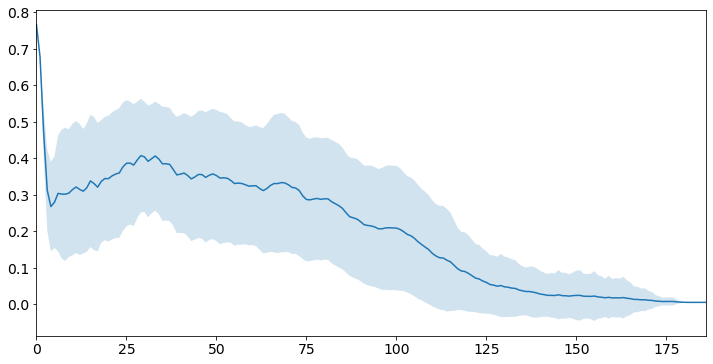

In [347]:
plot_latent_space(vae_ptb_raw, n=20, label=1, plot_individual=False)

#### Generate data using VAE

In [348]:
# Generate data using the trained VAE
def generate_training_samples_ptb(n, classes=[0,1]):
    
    # U.a.r choose a label from the input class label set
    labels = np.random.choice(classes, n, replace=True).reshape(-1, 1)
    labels_oh = oh_encoder.transform(labels)
    
    # Sample from latent space
    latent_samples = z_sample = np.random.normal(0, scale=1.0, size=(n, LATENT_SPACE_DIM))
    
    # Decode latent space
    decoded_samples = vae_ptb_raw.decoder.predict([latent_samples, labels_oh])
    
    return decoded_samples, labels_oh, labels

In [349]:
# Generate data using the trained VAE
X_add_ptb, Y_add_ptb_oh, Y_add_ptb = generate_training_samples_ptb(40000, classes=[0,1,1])

In [350]:
# Combine actual training data with the generated data
X_comb_ptb = np.concatenate((X_ptb, X_add_ptb))
Y_comb_ptb = np.concatenate((Y_ptb, Y_add_ptb.reshape(-1)))
Y_comb_ptb_oh = np.concatenate((Y_ptb_oh, Y_add_ptb_oh))
print("Combined training data shape:", X_comb_ptb.shape, Y_comb_ptb_oh.shape)

Combined training data shape: (50476, 187, 1) (50476, 5)


### Train baseline CNN on VAE generated data

In [351]:
# Create model
model_ptb_raw = get_model()

In [352]:
# Adjust classification head and loss
new_out = Dense(1, activation=activations.sigmoid, name="ptb_sigmoid")(model_ptb_raw.layers[-2].output)
model_ptb = Model(inputs=model_ptb_raw.input, outputs=new_out)

In [353]:
# Compile model
opt = optimizers.Adam(0.001)
model_ptb.compile(optimizer=opt, loss=losses.BinaryCrossentropy(), metrics=['acc'])
# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

In [354]:
# Parameter for ReduceLROnPlateau callback
min_lr           = 0.00005 # 0.00005
reduce_lr_factor = 0.5     # 0.8
patience         = 5
cooldown         = 5 


weight_file_path_vae_cnn_ptb = "./models/vae_data_cnn_ptb.h5"
checkpoint = ModelCheckpoint(weight_file_path_vae_cnn_ptb, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=8, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=reduce_lr_factor, patience=patience, cooldown=cooldown, min_lr=min_lr, verbose=2)

callbacks_list = [checkpoint, early, redonplat, PlotLossesKeras()]
# callbacks_list = [checkpoint, early, redonplat]

In [355]:
BATCH_SIZE_CNN = 128

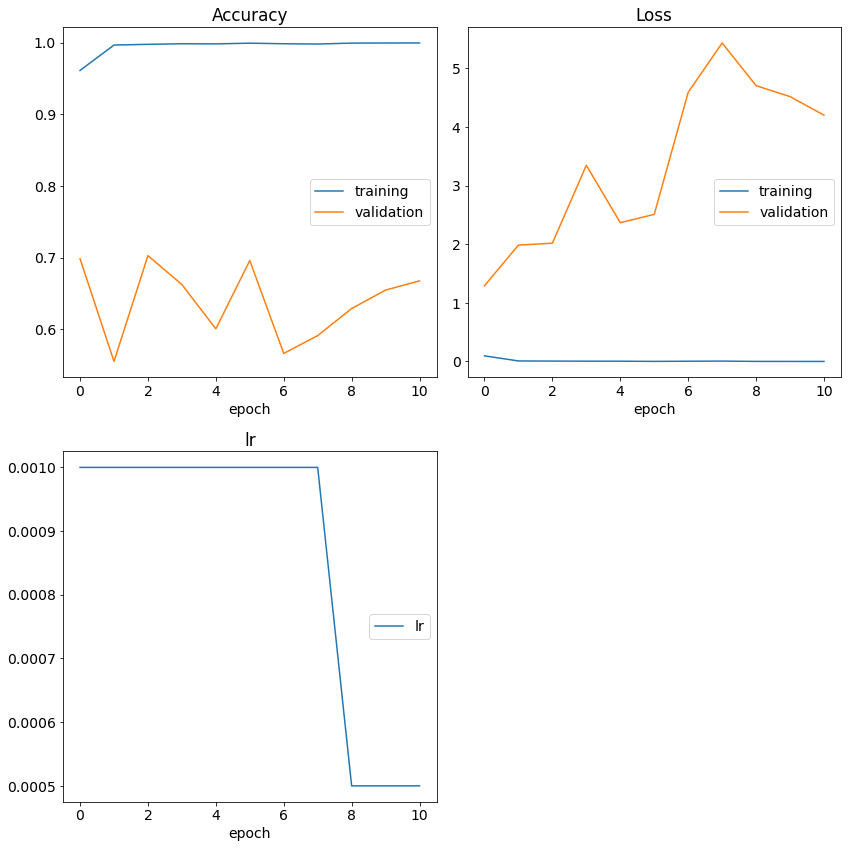

Accuracy
	training         	 (min:    0.961, max:    1.000, cur:    1.000)
	validation       	 (min:    0.555, max:    0.703, cur:    0.668)
Loss
	training         	 (min:    0.001, max:    0.096, cur:    0.001)
	validation       	 (min:    1.292, max:    5.432, cur:    4.201)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
Epoch 00011: early stopping


In [356]:
model_ptb.fit(
    X_add_ptb, Y_add_ptb, # Train on generated data alone
    epochs=EPOCHS, batch_size=BATCH_SIZE_CNN, verbose=True, 
    callbacks=callbacks_list,
    validation_data=(X_val_ptb, Y_val_ptb), # validate on actual data
    shuffle=True,
)

### Evaluation

In [357]:
model_ptb.load_weights(weight_file_path_vae_cnn_ptb)

f1 score micro:           0.71281
f1 score macro:           0.6389
accuracy score:           0.71281
balanced accuracy score:  0.63767
AuPR score:               0.88866
AuROC score:              0.75374


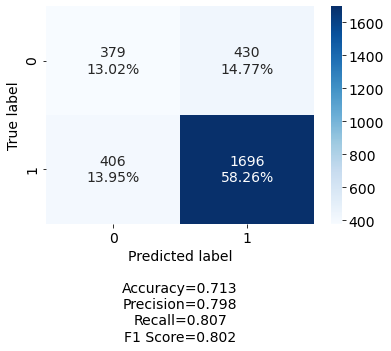

In [358]:
pred_test_proba = model_ptb.predict(X_test_ptb)
pred_test = [1 if x > 0.5 else 0 for x in pred_test_proba]

# print("F1 Macro:", f1_score(Y_test, pred_test, average="macro"))
display_result(Y_test_ptb, pred_test, curve=True, proba=pred_test_proba)